In [1]:
! pip install torch
! pip install torchvision
! python -m pip install -U scikit-image

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

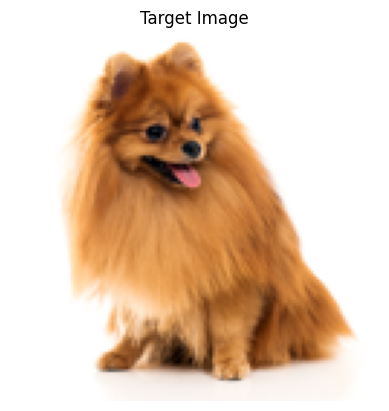

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load and prepare target image
target_image_path = 'cute-spitz-dog.jpg'
target_image = Image.open(target_image_path).convert('RGB')
target_image = target_image.resize((128, 128)) # Downsized to reduce complexity
transform = transforms.Compose([transforms.ToTensor()])
target_image_tensor = transform(target_image).unsqueeze(0)
# Show the target image
plt.imshow(target_image)
plt.title("Target Image")
plt.axis('off')
plt.show()

In [4]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class DeepDIPModel(nn.Module):
    def __init__(self):
        super(DeepDIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.conv6(x)
        return x

In [6]:
def ddpm_noise(image, alpha_t, noise_scale=1.0):
    alpha_t = torch.tensor(alpha_t, dtype=torch.float32)  # Ensure alpha_t is a tensor
    noise = torch.randn_like(image) * noise_scale  # Apply noise scaling
    noisy_image = torch.sqrt(alpha_t) * image + torch.sqrt(1 - alpha_t) * noise
    return noisy_image


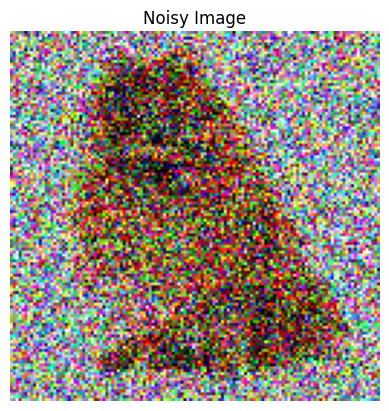

In [12]:
# Example alpha value and noise scale
alpha_t = 0.4
noise_scale = 0.5

# Generate a noisy image
noisy_image_tensor = ddpm_noise(target_image_tensor, alpha_t, noise_scale)

# Convert the noisy image tensor to a NumPy array for visualization
noisy_image_np = noisy_image_tensor.squeeze().permute(1, 2, 0).numpy()

# Show the noisy image
plt.imshow(noisy_image_np)
plt.title("Noisy Image")
plt.axis('off')
plt.show()

noisy_image_pil = Image.fromarray((noisy_image_np * 255).astype(np.uint8))
noisy_image_pil.save("noisy_image.jpg")

Epoch [0/200], Loss: 1.6449
PSNR: 8.2470, SSIM: 0.5766
Epoch [50/200], Loss: 0.0624
PSNR: 24.7641, SSIM: 0.7515
Epoch [100/200], Loss: 0.0469
PSNR: 25.8404, SSIM: 0.7929
Epoch [150/200], Loss: 0.0450
PSNR: 25.8429, SSIM: 0.8080
Epoch [200/200], Loss: 0.0576
PSNR: 22.8813, SSIM: 0.8262


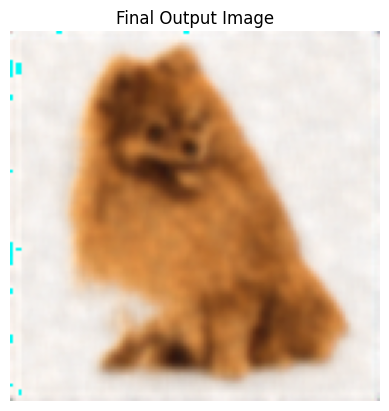

In [16]:
# Initialize the DIP models, loss function, and optimizer
dip_model = DIPModel()
# deep_dip_model = DeepDIPModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(dip_model.parameters(), lr=0.001)

# Training parameters
epochs = 200
alpha_schedule = [0.1, 0.3, 0.5, 0.7, 0.9]

# Training loop
for epoch in range(epochs + 1):
    epoch_loss = 0
    for alpha_t in alpha_schedule:
        noisy_image_tensor = ddpm_noise(target_image_tensor, alpha_t, 0.5)

        optimizer.zero_grad()
        output = dip_model(noisy_image_tensor)
        loss = criterion(output, target_image_tensor)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 50 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}')

        # Calculate PSNR and SSIM
        output_image = output.detach().squeeze().permute(1, 2, 0).numpy()
        target_image_np = target_image_tensor.squeeze().permute(1, 2, 0).numpy()

        current_psnr = psnr(target_image_np, output_image)
        current_ssim = ssim(target_image_np, output_image, win_size=7, channel_axis=2, data_range=1.0)

        print(f'PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}')

        # Save intermediate results for qualitative evaluation
        intermediate_output_image = transforms.ToPILImage()(output.squeeze())
        intermediate_output_image.save(f'./intermediate_output/intermediate_output_image_epoch_{epoch}.jpg')

# Save the final DIP-generated image
final_output_image = transforms.ToPILImage()(output.squeeze())
final_output_image.save('final_dip_generated_image.jpg')

# Show the noisy image
plt.imshow(final_output_image)
plt.title("Final Output Image")
plt.axis('off')
plt.show()
